In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-16 04:00:25.686908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 04:00:25.686946: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

Export h5 (experimental)

In [4]:
# dataset_name = 'BrainChromatin'
# modality_names = ['RNA', 'ATAC']
# data1 = pd.read_csv("../data/brainchromatin/multiome_rna_counts.tsv", delimiter='\t').transpose()

# data2 = pd.read_csv("../data/brainchromatin/multiome_atac_gene_activities.tsv", delimiter='\t', nrows=35000).transpose()  # Only a subset
# data2 = data2.transpose()[data1.index].transpose()

# dataset = [data1, data2]
# features = [np.array(d.columns) for d in dataset]

In [5]:
# import h5py

# data = np.concatenate(dataset, axis=1).T
# shape = np.array(np.shape(data)).astype('int')
# data = data.flatten(order='F').astype('float')
# barcodes = np.array(['Unknown' for _ in range(shape[1])]).astype('|S')
# indices = np.array(shape[1] * [i for i in range(shape[0])]).astype('int')
# indptr = np.array([i*shape[0] for i in range(shape[1]+1)]).astype('int')

# _all_tag_keys = np.array(['genome']).astype('|S')
# # First dataset should be RNA, second ATAC
# feature_type = np.array(dataset[0].shape[1] * ['Gene Expression'] + dataset[1].shape[1] * ['Peaks']).astype('|S')
# genome = np.array(['Unknown' for _ in range(shape[0])]).astype('|S')
# # id = np.array(['Unknown' for _ in range(shape[0])]).astype('|S')
# id = np.array(list(features[0]) + list(features[1])).astype('|S')
# # name = np.array(['Unknown' for _ in range(shape[0])]).astype('|S')
# name = np.array(list(features[0]) + list(features[1])).astype('|S')

# with h5py.File('../../../babel/test.h5', 'w') as f: # '../babel_data/test.h5'
#     mat = f.create_group('matrix')
#     mat.create_dataset('barcodes', data=barcodes)
#     mat.create_dataset('data', data=data)
#     mat.create_dataset('indices', data=indices)
#     mat.create_dataset('indptr', data=indptr)
#     mat.create_dataset('shape', data=shape)

#     fea = mat.create_group('features')
#     fea.create_dataset('_all_tag_keys', data=_all_tag_keys)
#     fea.create_dataset('feature_type', data=feature_type)
#     fea.create_dataset('genome', data=genome)
#     fea.create_dataset('id', data=id)
#     fea.create_dataset('name', data=name)
    
# # try:
# #     f.close()
# # except:
# #     pass
# # f = h5py.File('../babel_data/test.h5', 'r')

# # for n in f['matrix']:
# #     print(n)
# #     print(f['matrix'][n])
# #     print()
    
# # f.close()

# # import scipy
# # scipy.sparse.csc_matrix((data, indices, indptr)).toarray().shape

# # # try:
# # #     samp.close()
# # # except:
# # #     pass
# # # samp = h5py.File('../data/babel/DM_rep4.h5', 'r')

# # # for n in samp['matrix']['features']:
# # #     print(n)
# # #     print(samp['matrix']['features'][n])
# # #     print()
# # # print(samp['matrix']['features']['_all_tag_keys'][()])
# # # print(samp['matrix']['features']['id'][()])
# # # print(samp['matrix']['barcodes'][()])
    
# # # samp.close()
# # import scanpy as sc
# sc.read_10x_h5('../../../babel/test.h5', gex_only=False)
# # sc.read_10x_h5('../data/babel/DM_rep4.h5', gex_only=False)

Back to normal things

In [6]:
from sklearn.decomposition import PCA

dataset_name = 'BrainChromatin'
modality_names = ['RNA', 'ATAC']
data1 = pd.read_csv("../data/brainchromatin/multiome_rna_counts.tsv", delimiter='\t').transpose()
# PCA
# proc = PCA(n_components=32).fit_transform(data1)
# d1 = pd.DataFrame(proc)
# d1.index = data1.index
# data1 = d1

data2 = pd.read_csv("../data/brainchromatin/multiome_atac_gene_activities.tsv", delimiter='\t', nrows=35000).transpose()  # Only a subset
# PCA
# proc = PCA(n_components=32).fit_transform(data2)
# d2 = pd.DataFrame(proc)
# d2.index = data2.index
# data2 = d2
data2 = data2.transpose()[data1.index].transpose()

meta = pd.read_csv("../data/brainchromatin/multiome_cell_metadata.txt", delimiter='\t')
meta_names = pd.read_csv("../data/brainchromatin/multiome_cluster_names.txt", delimiter='\t')
meta_names = meta_names[meta_names['Assay'] == 'Multiome ATAC']
meta = pd.merge(meta, meta_names, left_on='ATAC_cluster', right_on='Cluster.ID', how='left')
meta.index = meta['Cell.ID']

type1 = type2 = np.array(meta.transpose()[data1.index].transpose()['Cluster.Name'])
fname1, fname2 = data1.columns, data2.columns
data1 = data1.to_numpy()
data2 = data2.to_numpy()

# Sampling
split = 500 # data1.shape[0]
data_row_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
data1, data2, type1, type2 = (x[data_row_idx] for x in (data1, data2, type1, type2))
split_feat_1 = 2000 # data1.shape[1]
data_col1_idx = np.random.choice(range(data1.shape[1]), split_feat_1, replace=False)
split_feat_2 = 2000 # data2.shape[1]
data_col2_idx = np.random.choice(range(data2.shape[1]), split_feat_2, replace=False)
data1, fname1 = data1[:, data_col1_idx], fname1[data_col1_idx]
data2, fname2 = data2[:, data_col2_idx], fname2[data_col2_idx]

# Labels
labels = [type1, type2]
features = [fname1, fname2]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

In [7]:
# Group labels
group = ['GluN3', 'GluN4', 'IN1', 'GluN2', 'IN2', 'GluN6', 'GluN5', 'RG',
       'nIPC', 'GluN1', 'mGPC/OPC', 'IN3', 'IN4', 'SP', 'GluN7',
       'MG/EC/Peric.']
conv =  ['GluN', 'GluN', 'IN', 'GluN', 'IN', 'GluN', 'GluN', 'RG',
        'nIPC', 'GluN', 'mGPC/OPC', 'IN', 'IN', 'SP', 'GluN',
        'MG/EC/Peric.']
group_conv = {g:c for g, c in zip(group, conv)}
labels = [np.array([group_conv[l] for l in label]) for label in labels]

In [8]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [ ]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 128
pca_dim = [32, 32]
dist_method = 'euclidean'

# ComManDo

In [29]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
# cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
# cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 2000)
Dataset 1: (500, 2000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:1.9908 alpha:0.7818
epoch:[1000/2000] err:1.9100 alpha:0.9428
epoch:[1500/2000] err:1.9164 alpha:1.0435
epoch:[2000/2000] err:1.9264 alpha:1.1067
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.190668
epoch:[1000/2000]: loss:1.004818
epoch:[1500/2000]: loss:0.954440
epoch:[2000/2000]: loss:0.944204
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.23164704200462438
Correspondence: 9.875286877999315
Mapping: 103.19933659999515
Total: 113.30627051999909



In [11]:
# Imputation
cm_im = ComManDo(**kwargs)
cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (400, 2000)
Dataset 1: (400, 2000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:2.0013 alpha:0.9411
epoch:[1000/2000] err:1.9616 alpha:1.0551
epoch:[1500/2000] err:1.9951 alpha:1.1242
epoch:[2000/2000] err:2.0238 alpha:1.1672
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.950067
epoch:[1000/2000]: loss:0.916946
epoch:[1500/2000]: loss:0.896757
epoch:[2000/2000]: loss:0.874189
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.1256139710021671
Correspondence: 7.355757025987259
Mapping: 121.5235421010002
Total: 129.00491309798963



# Comparison Methods

In [12]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
# nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
# lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
# cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

In [13]:
# MMD-MA
# from sklearn.metrics import pairwise_distances
# mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)

# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 2000)
Dataset 1: (500, 2000)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:10.3908 alpha:4.1912
epoch:[200/2000] err:1.3823 alpha:0.5627
epoch:[300/2000] err:2.1385 alpha:0.6806
epoch:[400/2000] err:2.0735 alpha:0.7346
epoch:[500/2000] err:1.9915 alpha:0.7814
epoch:[600/2000] err:1.9472 alpha:0.8208
epoch:[700/2000] err:1.9258 alpha:0.8557
epoch:[800/2000] err:1.9159 alpha:0.8874
epoch:[900/2000] err:1.9116 alpha:0.9162
epoch:[1000/2000] err:1.9100 alpha:0.9425
epoch:[1100/2000] err:1.9098 alpha:0.9666
epoch:[1200/2000] err:1.9107 alpha:0.9885
epoch:[1300/2000] err:1.9121 alpha:1.0085
epoch:[1400/2000] err:1.9141 alpha:1.0267
epoch:[1500/2000] err:1.9163 alpha:1.0433
epoch:[1600/2000] err:1.9186 alpha:1.0585
epoch:[1700/2000] err:1.9208 alpha:1.0723
epoch:[1800/2000] err:1.9228 alpha:1.0848
epoch:[1900/2000] err:1.9247 alpha:1.0962
epoch:[2000/2000] err:1

In [14]:
# Imputation
if False:
    imputation_name = 'Babel'
    # Load Babel file
else:
    imputation_name = 'NN'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [30]:
# integrated_data = [cm_data, nlma_data, lma_data, cca_data, mmd_ma_data, uc_data]
# integrated_names = ['JAMIE', 'Nonlinear\nManifold\nAlignment', 'Linear\nManifold\nAlignment', 'CCA', 'MMD-MA', 'Unioncom']
integrated_data = [cm_data, nlma_data, lma_data, cca_data, uc_data]
integrated_names = ['JAMIE', 'Nonlinear\nManifold\nAlignment', 'Linear\nManifold\nAlignment', 'CCA', 'Unioncom']
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]
# colors = ['blue', 'red', 'green', 'm', 'yellow', 'teal']
colors = ['blue', 'red', 'green', 'm', 'teal']
style='whitegrid'

sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

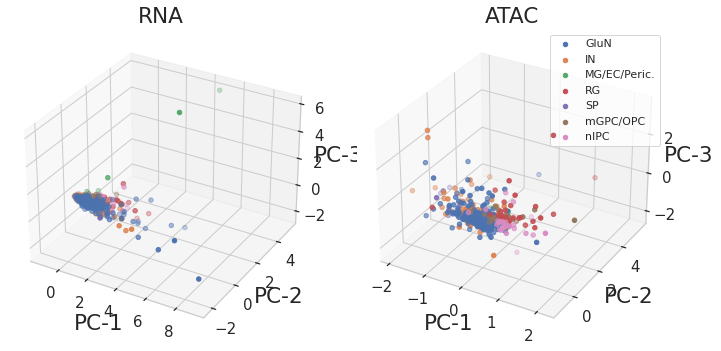

In [31]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-PCA.png')

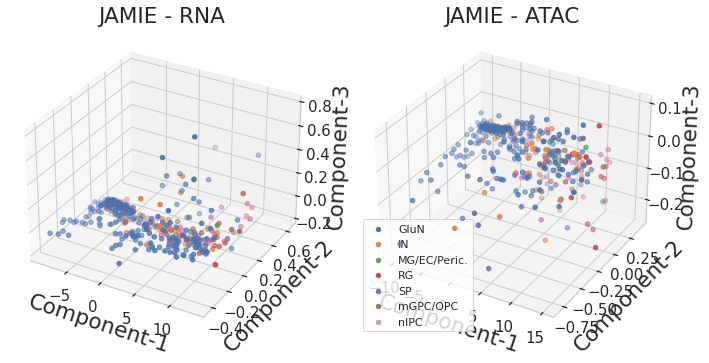

In [32]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

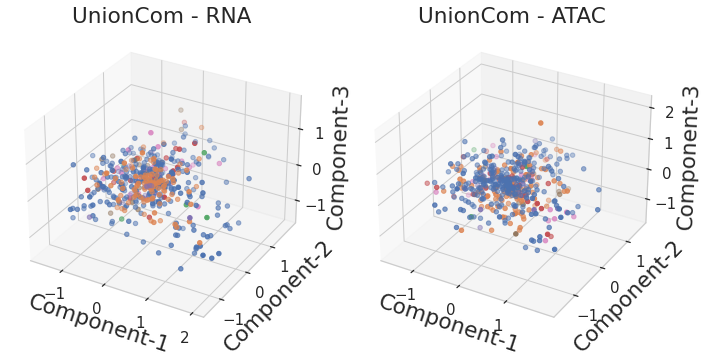

In [18]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(uc_data, labels, ['UnionCom - ' + mn for mn in modality_names], legend=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-UnionCom.png')

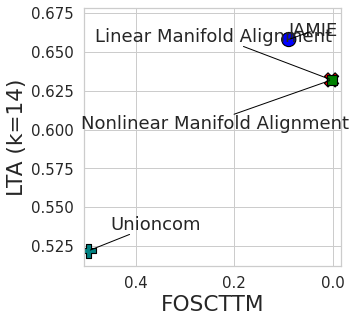

In [19]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, exclude=[3], colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

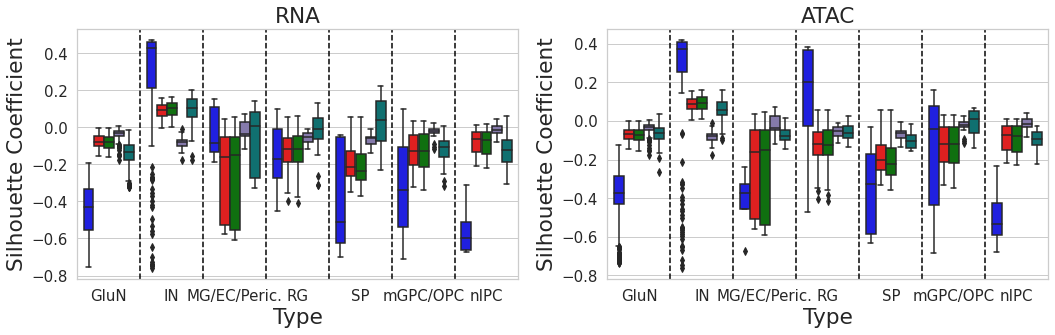

In [33]:
plt.figure(figsize=(15, 5))
plot_silhouette(integrated_data, labels, integrated_names, modality_names, colors=colors)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

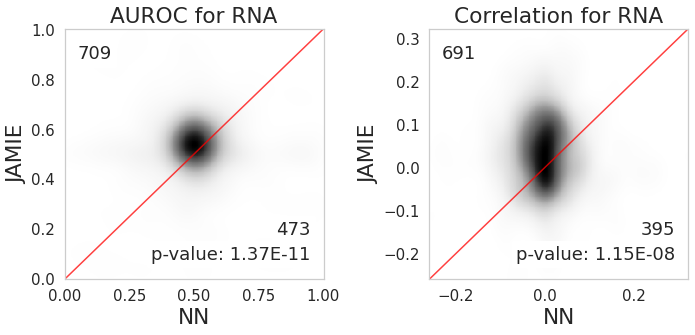

In [21]:
import warnings
plt.figure(figsize=(10, 5))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

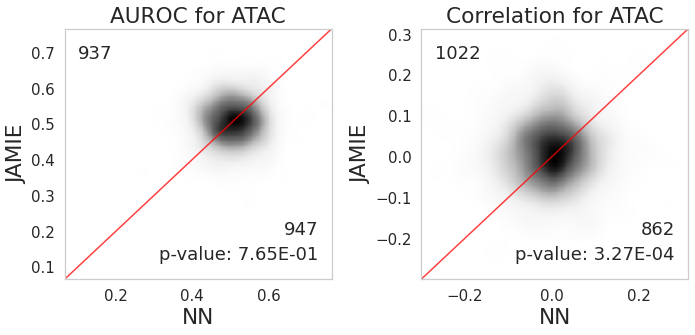

In [22]:
import warnings
plt.figure(figsize=(10, 5))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

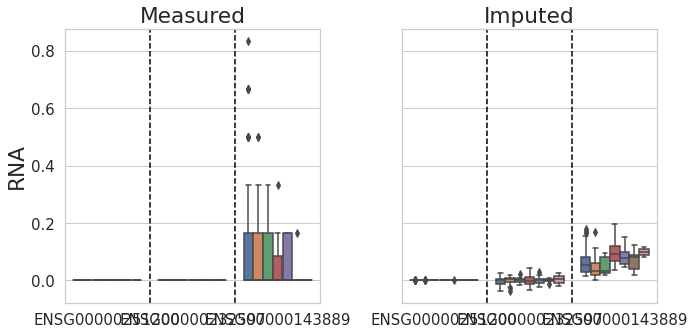

In [44]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], supert=modality_names[0], fnames=2*[features[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

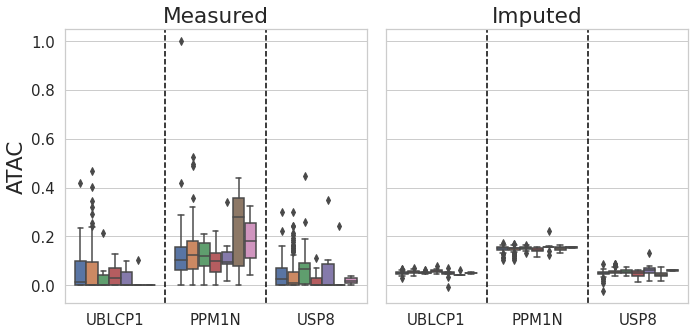

In [45]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], supert=modality_names[1], fnames=2*[features[1]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

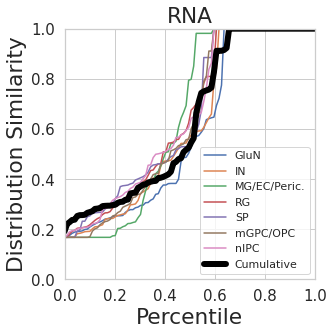

In [25]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png')

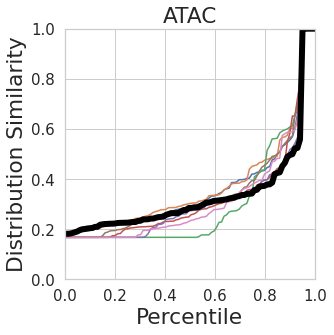

In [26]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], legend=False)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png')

# Explanation

In [27]:
sns.set(style=style)

In [34]:
# Integration
kwargs_thin = kwargs
kwargs_thin['output_dim'] = 1
cm_thin = ComManDo(**kwargs_thin)
cm_thin_data = cm_thin.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 2000)
Dataset 1: (500, 2000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:1.9908 alpha:0.7818
epoch:[1000/2000] err:1.9100 alpha:0.9428
epoch:[1500/2000] err:1.9164 alpha:1.0435
epoch:[2000/2000] err:1.9264 alpha:1.1067
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.394533
epoch:[1000/2000]: loss:1.157933
epoch:[1500/2000]: loss:1.115293
epoch:[2000/2000]: loss:1.084366
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.7298248189908918
Correspondence: 31.61733418700169
Mapping: 438.26388795000094
Total: 470.6110469559935



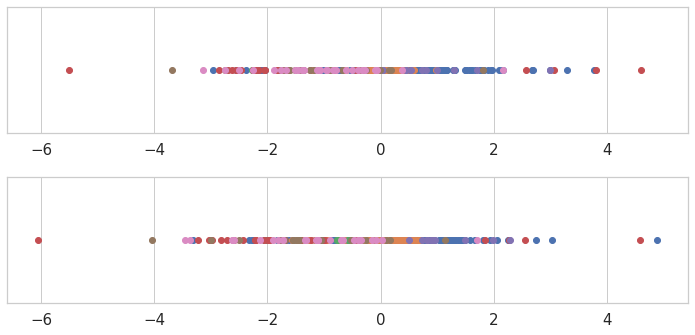

In [35]:
plt.figure(figsize=(10, 5))
axs = plt.gcf().subplots(2, 1)
for i, ax in enumerate(axs):
    for l in np.unique(np.concatenate(labels)):
        ax.scatter(cm_thin_data[i][labels[i] == l], np.zeros_like(cm_thin_data[i][labels[i] == l]), label=l)
    ax.set_yticks([])
min_lim = min(axs[0].get_xlim()[0], axs[1].get_xlim()[0])
max_lim = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
for ax in axs:
    ax.set_xlim([min_lim, max_lim])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Line.png');

In [36]:
%%capture
import shap

def join_data(data):
    return np.concatenate(data, axis=1)
def sep_data(data, split):
    return [data[:, :split], data[:, split:]]
def detach_data(data):
    return [x.detach() for x in data]
def make_tens(data):
    return [torch.Tensor(x) for x in data]
def prep_data(data, m):
    return [m.preprocessing[i](x) for i, x in enumerate(data)]

target_feature = 0
if pca_dim is not None and pca_dim[0] is not None:
    split = pca_dim[0]
else:
    split = dataset[0].shape[1]
# model = lambda x: join_data(detach_data( cm.model(*make_tens(prep_data(sep_data(x, split), cm.model)), corr=torch.Tensor(np.eye(len(x))))[0] ))[:, target_feature]
# data = join_data(dataset)
model = lambda x: join_data(detach_data( cm_thin.model(*make_tens(sep_data(x, split)), corr=torch.Tensor(np.eye(len(x))))[0] ))[:, target_feature]
data = join_data(prep_data(dataset, cm_thin.model))

# Explainer
explainer = shap.Explainer(model, np.median(data, axis=0).reshape((1, -1)), feature_names=features[0]+features[1], output_names=['Latent Feature 0'])
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    shap_values = explainer(data, max_evals=600)
    
# Kernel Explainer
kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=features[0]+features[1], output_names=['Latent Feature 0'])
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    kshap_values = kexplainer.shap_values(data, nsamples=100)

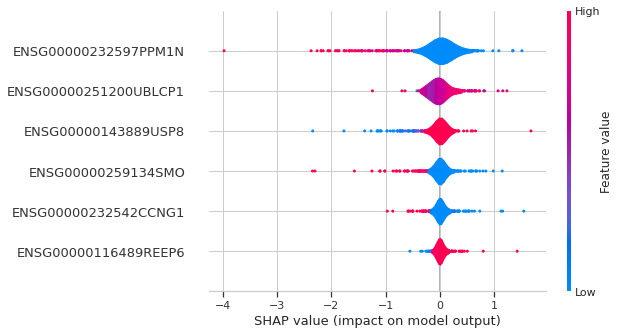

In [37]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=6, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

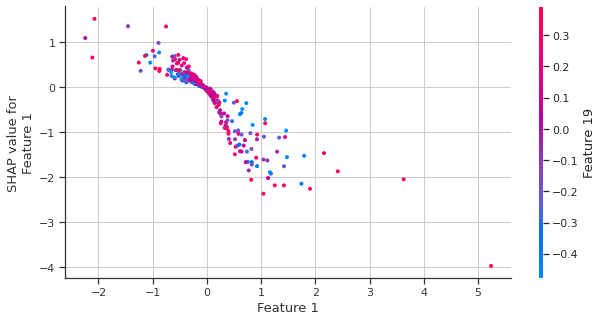

In [38]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

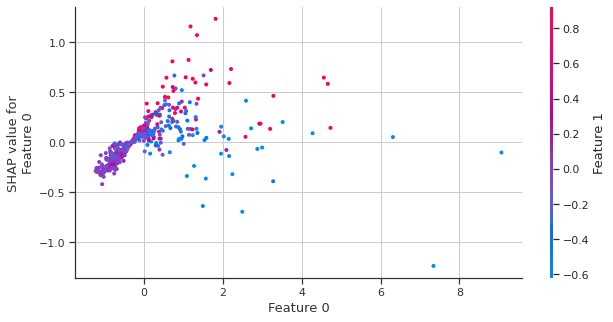

In [39]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][1], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep2.png');

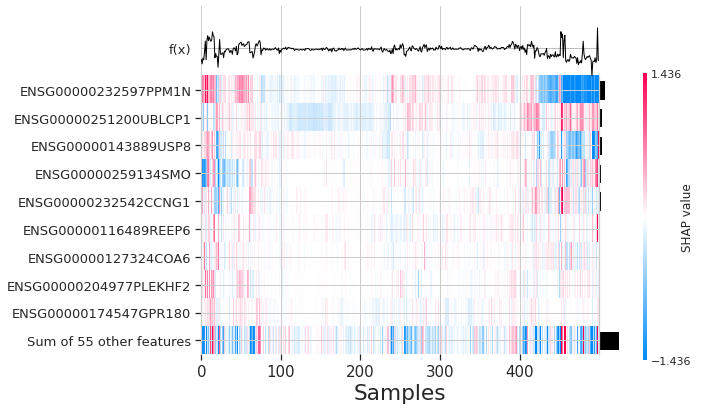

In [40]:
shap.plots.heatmap(shap_values, show=False)
plt.gca().set_xlabel('Samples')
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

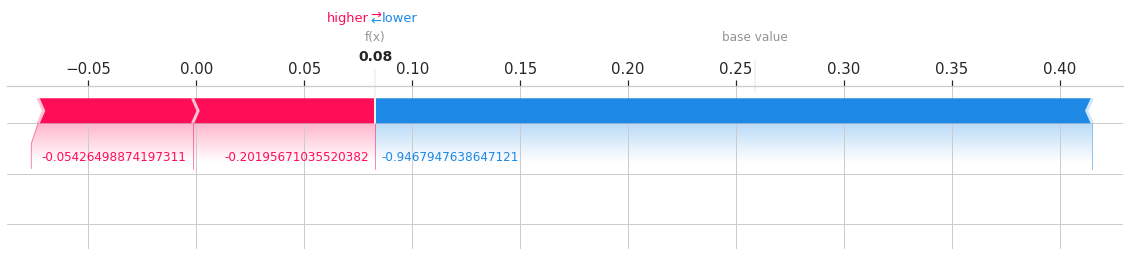

In [41]:
shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [42]:
shap.initjs()
shap.force_plot(kexplainer.expected_value, kshap_values, data)

# Sample Plots

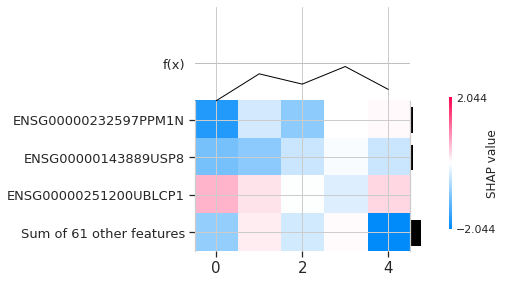

In [43]:
shap.plots.heatmap(shap_values[:10:2], show=False, plot_width=7, max_display=4)
plt.gca().set_xlabel(None)
plt.savefig('./output_figures/sample_heatmap.png');